# UFPE - Métodos computacionais de estrutura eletrônica (FIS790)
## Estrutura de bandas e DOS para N-ZZNT
### Franklin Ferreira

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# N-ZZNT Bandstructure

In [3]:
def diagonalize(N, hamiltonian_function):
    k_points = 1000
    k_array = np.linspace(-np.pi/a, np.pi/a, k_points)
    E_array = np.zeros((k_points, 4*N))
    
    for idx, k in enumerate(k_array):
        H = hamiltonian_function(k, N, alpha, beta, a)
        E_array[idx] = np.linalg.eigvalsh(H)
    
    return E_array

In [4]:
def make_NZZNT_hamiltonian(k, N, alpha=1.0, beta=-2.0, a=1.0):

    H = np.identity(4*N, dtype=complex) * alpha

    # Upper and lower diagonal

    for i in range(4*N):
        for j in range(4*N):
            if j == i+1 or j == i-1:
                H[i,j] = beta

    # Antidiagonal    
    for i in range(0, 2*N, 2):
        H[i, 4*N-1-i] = beta
        if i+1 < 2*N: 
            H[i+1, 4*N-2-i] = beta*np.exp(-1j*k*a)

    for i in range(4*N-1, 2*N-1, -2):
        H[i, 4*N-1-i] = beta
        if i-1 >= 2*N: 
            H[i-1, 4*N-i] = beta*np.exp(1j*k*a)

    # NZZNT

    H[0, 2*N-1] = H[2*N-1, 0] = beta
    H[2*N, 4*N-1] = H[4*N-1, 2*N] = beta
    
    return H

In [5]:
alpha = 0.0
beta = -2.8
a = 1.42

k_array = np.linspace(-np.pi/a, np.pi/a, 1000)

E_Z9 = diagonalize(N=9, hamiltonian_function=make_NZZNT_hamiltonian)
E_Z10 = diagonalize(N=10, hamiltonian_function=make_NZZNT_hamiltonian)
E_Z11 = diagonalize(N=11, hamiltonian_function=make_NZZNT_hamiltonian)
E_Z12 = diagonalize(N=12, hamiltonian_function=make_NZZNT_hamiltonian)

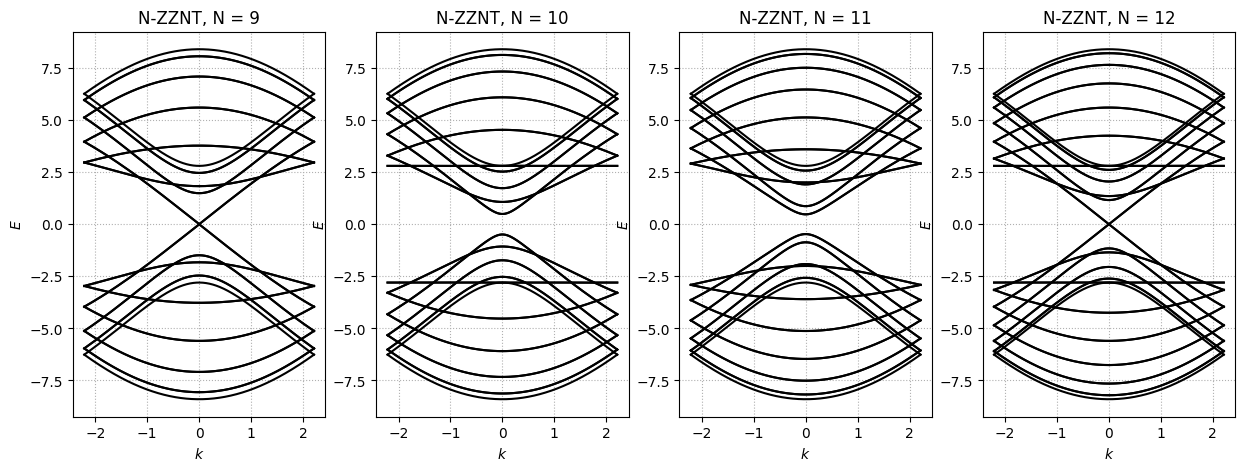

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.plot(k_array, E_Z9, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 9')
plt.grid(ls=':')

plt.subplot(1,4,2)
plt.plot(k_array, E_Z10, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 10')
plt.grid(ls=':')

plt.subplot(1,4,3)
plt.plot(k_array, E_Z11, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 11')
plt.grid(ls=':')

plt.subplot(1,4,4)
plt.plot(k_array, E_Z12, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 12')
plt.grid(ls=':')

plt.show()

# DOS (by definition)

In [8]:
def get_dos(Ek, E, eta):
    dos = 0.0

    for i in range(len(E.flatten())):
        dos += eta / (eta**2 + (Ek - E.flatten()[i])**2)
    
    return dos

In [9]:
eta = 1e-2
Ek = np.linspace(-9.0, 9.0, 1000)

dos_z9 = get_dos(Ek, E_Z9, eta)
dos_z10 = get_dos(Ek, E_Z10, eta)
dos_z11 = get_dos(Ek, E_Z11, eta)

In [22]:
# Normalization

from scipy import integrate

A9 = integrate.simps(dos_z9, Ek)
A10 = integrate.simps(dos_z10, Ek)
A11 = integrate.simps(dos_z11, Ek)

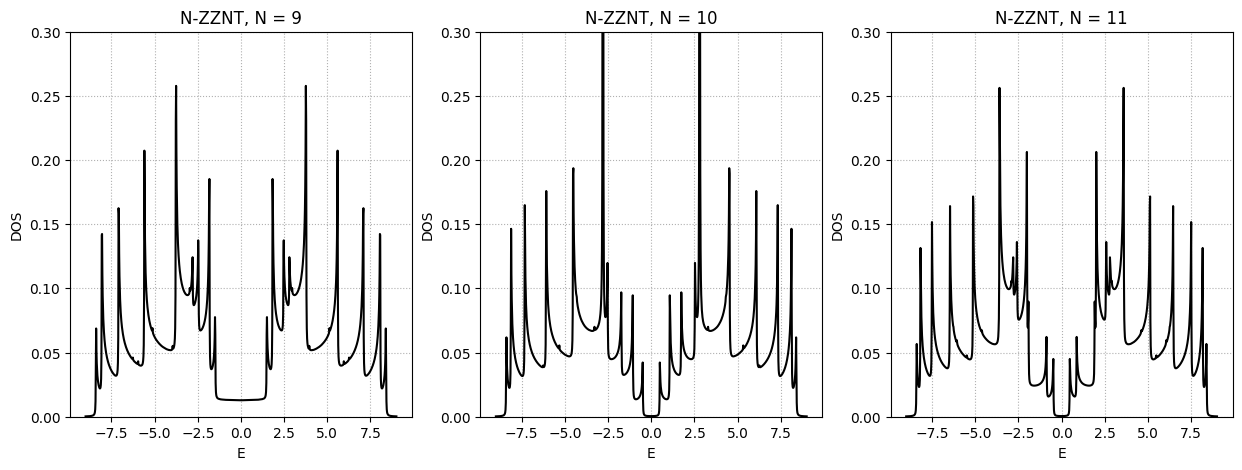

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(Ek, dos_z9/A9, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.grid(ls=':')
plt.ylim(0, 0.3)
plt.title(f'N-ZZNT, N = 9')

plt.subplot(1,3,2)
plt.plot(Ek, dos_z10/A10, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.grid(ls=':')
plt.ylim(0, 0.3)
plt.title(f'N-ZZNT, N = 10', c='k')

plt.subplot(1,3,3)
plt.plot(Ek, dos_z11/A11, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.grid(ls=':')
plt.ylim(0, 0.3)
plt.title(f'N-ZZNT, N = 11')

plt.show()

# DOS (by recursive Green's function)

In [12]:
def make_green_hamiltonian(N, alpha, beta):
    NN = 4*N
    H = np.identity(NN, dtype=complex) * alpha

    for i in range(NN):
        for j in range(NN):
            if i == j+1 or i == j-1:
                H[i,j] = beta

    for i in range(1, 2*N, 2):
        H[i, NN-i-1] = H[NN-i-1, i] = beta

    H[0, 2*N-1] = H[2*N-1, 0] = beta
    H[2*N, NN-1] = H[NN-1, 2*N] = beta
    return H

In [13]:
def make_green_V(N, beta):
    NN = 4*N
    V = np.zeros((NN, NN), dtype=complex)

    for i in range(0, 2*N, 2):
        V[NN-i-1, i] = beta
    return V

In [14]:
def make_green_dos(H, V, N, E, eta):
    E_points = len(E)
    NN = 4*N
    dos_array = np.zeros(E_points)

    V_A = V.conj().T 

    for i in range(E_points):
        G0 = np.linalg.inv((E[i] + 1j*eta)*np.identity(NN) - H)
        SR = G0
        SL = G0
        for n in range(n_max):
            SR = np.linalg.inv(np.identity(NN) - G0 @ V @ SR @ V_A) @ G0
            SL = np.linalg.inv(np.identity(NN) - G0 @ V_A @ SL @ V) @ G0

        g = np.linalg.inv(np.identity(NN) - SR @ V_A @ SL @ V) @ SR

        dos_array[i] = -np.trace(g).imag
    return dos_array

In [15]:
alpha = 0.0
beta = -2.8

eta = 1e-2
n_max = 800

E_points = 500
E = np.linspace(-9.0, 9.0, E_points)

In [16]:
N = 9
H = make_green_hamiltonian(N, alpha, beta)
V = make_green_V(N, beta)

dos_g_9 = make_green_dos(H, V, N, E, eta)

In [17]:
N = 10
H = make_green_hamiltonian(N, alpha, beta)
V = make_green_V(N, beta)

dos_g_10 = make_green_dos(H, V, N, E, eta)

In [18]:
N = 11
H = make_green_hamiltonian(N, alpha, beta)
V = make_green_V(N, beta)

dos_g_11 = make_green_dos(H, V, N, E, eta)

In [26]:
# Normalization

AG9 = integrate.simps(dos_g_9, E)
AG10 = integrate.simps(dos_g_10, E)
AG11 = integrate.simps(dos_g_11, E)

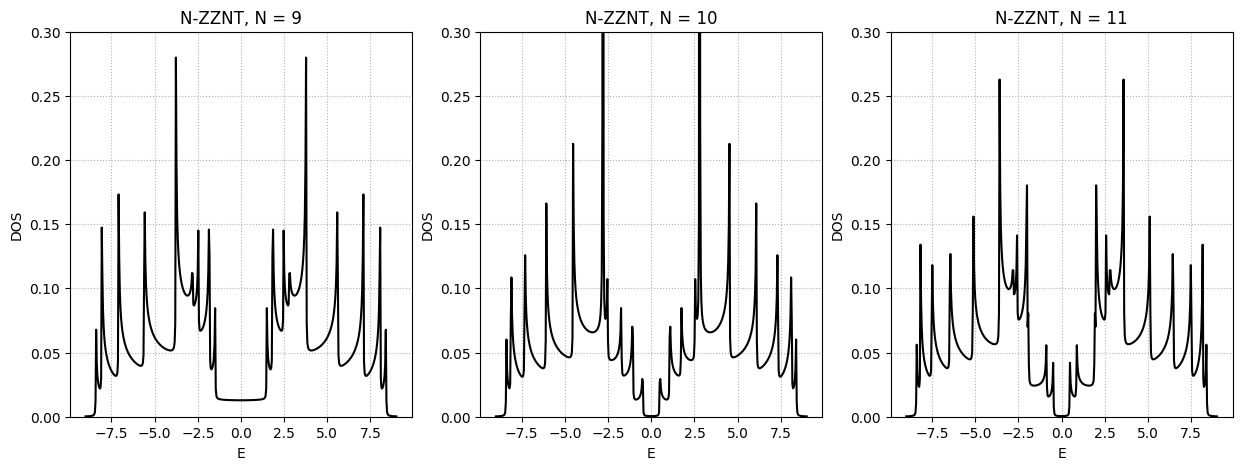

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(E, dos_g_9/AG9, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.ylim(0, 0.3)
plt.grid(ls=':')
plt.title(f'N-ZZNT, N = 9')

plt.subplot(1,3,2)
plt.plot(E, dos_g_10/AG10, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.ylim(0, 0.3)
plt.grid(ls=':')
plt.title(f'N-ZZNT, N = 10', c='k')

plt.subplot(1,3,3)
plt.plot(E, dos_g_11/AG11, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.ylim(0, 0.3)
plt.grid(ls=':')
plt.title(f'N-ZZNT, N = 11')

plt.show()